---
layout: code-post
title: Training neural nets - Adam
tags: [neural nets]
---

While stochastic gradient descent -- referred to in the 
[backpropogation post](https://kevinnowland.com/code/2020/05/04/backpropagation.html))
is the traditional optimization algorithm used in training neural nets, the
default might be becoming Adam a/k/a Adaptive Momentum. The algorithm was
presented by Kingma and Ba in a [2015 conference paper](https://arxiv.org/abs/1412.6980).
While each coefficient moves in the opposite direction of the derivative with
respect to that coefficient, the step size is _adaptive_ based on the first and
second moment of its derivative. This way if the momentum (second moment) is large, 
a smaller stepsize is taken to compensate and prevent overshooting.

Outline:
- Algorithm
- Neural net implementation
- Comparing to SGD

## Algorithm

The intuitive presentation of the algorithm presented by the authors is
the following:

- Set the stepsize $\alpha$
- Set decay rates $\beta\_1$, $\beta\_2$ in $[0, 1)$
- Set $\epsilon > 0$ (very small)
- Initialize parameters $\theta$
- Initialize the first moment $m\_0$ and second moment $v\_0$ to zero
- Until convergence:
  - Set $g\_t$ to be the gradient
  - Set $m\_t = \beta\_1\cdot m\_{t-1} + (1-\beta\_1)\cdot g\_t$
  - Set $v\_t = \beta\_2\cdot v\_{t-1} + (1-\beta\_2)\cdot g\_t^2$
  - Set $\hat m\_t = m\_t / (1 - \beta\_1^t)$
  - Set $\hat v\_t = v\_t / (1 - \beta\_2^t)$
  - Update parameters $\theta\_t = \theta\_{t-1} - \alpha\cdot \hat m\_t/(\sqrt{\hat v\_t}+\epsilon)$
  
All vector operations are elementwise, and as a result, the update is not purely in the
direction of the gradient, even if each coefficient is individually moving in the opposite
direction of its derivative. The suggested default parameters are $\alpha=.001$, $\beta\_1=0.9$,
$\beta\_2=0.999$, and $\epsilon=1\times10^{-8}$.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import copy

We start by implementing as simple version of the Adam algorithm that requires
both the scalar funciton f as well as its gradient f_prime to be calculated
ahead of time. You give it an initial value and how many steps you'd like
it to take (along with optional parameters for the true minimum value and
tolerance you allow yourself to be off from it).

In [60]:
def adam_simple(f, f_prime, initial_value, max_steps, min_value=None, tolerance=None, skip_data=100):
    """ adam for a simple function f with gradient f_prime.
    This will return some data for plotting. """
    
    t = 0
    theta = initial_value
    alpha = 0.001
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-8
    
    m = np.zeros(len(theta))
    v = np.zeros(len(theta))
    
    data = []
    keep_going = True
    
    while keep_going:
        
        if t % skip_data == 0:
            data.append((t, theta, f(theta)))
        
        t = t + 1
        g = f_prime(theta)
        m = beta_1 * m + (1 - beta_1) * g
        v = beta_1 * v + (1 - beta_2) * (g*g)
        
        m_hat = m / (1 - pow(beta_1, t))
        v_hat = v / (1 - pow(beta_2, t))
        
        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + eps)
        
        if min_value is None or tolerance is None:
            keep_going = t <= max_steps
        else:
            keep_going = t <= max_steps and np.abs(min_value - f(theta)) >= tolerance
            
    if t != data[-1][0]:
        data.append((t, theta, f(theta)))
        
    return data
    

We implement the simple function $x^2 + xy + y^2$ and its gradient.

In [75]:
def foo(x):
    return x[0]**2 + x[0] * x[1] + x[1]**2

def foo_prime(x):
    return np.array([2 * x[0] + x[1], 2*x[1] + x[0]])

And here we run adam and plot the results on a background colored
by the values of the function.

In [61]:
data = adam_simple(foo, foo_prime, np.array([-7.4, 2.113]), 2000, 0, 1e-5, 1)

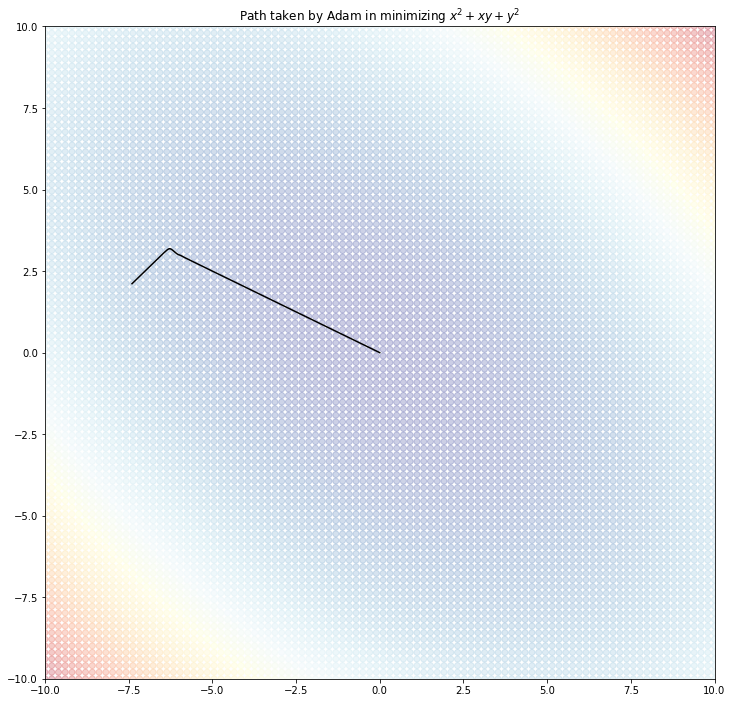

In [108]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))

x_vals = [d[1][0] for d in data]
y_vals = [d[1][1] for d in data]

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.plot(x_vals, y_vals, c="black")

x = np.linspace(-10, 10, 100)
xy = product(x, x)
df_background = pd.DataFrame(xy, columns=['x', 'y'])

xy = df_background.values
df_background['value'] = xy[:,0]*xy[:,0] + xy[:,0]*xy[:,1] + xy[:,1]*xy[:,1]

# plotting
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.scatter(df_background['x'],
           df_background['y'],
           c=-df_background['value'],
           cmap='RdYlBu',
           marker='o',
           alpha=0.25)

ax.set_title("Path taken by Adam in minimizing $x^2 + xy + y^2$")

plt.show()

And low and behold with a slight detour toward the axis $y=x$, we quickly zero in on 
the minimum at $(0, 0)$.

## Neural Net implementation

Now we take our ever expanding neural net code and implement both Adam and SGD. Note that
both use backpropagation to calculate the gradient, just the usage of the gradient
is different.

In [138]:
def add_weights(k1, w1, k2, w2):
    """ k1*w1 + k2*w2 for neural net weights w1 and w2 """
    return [k1*w1[i] + k2*w2[i] for i in range(len(w1))]

def power_weights(w, k):
    """ return the weights to the kth power (elementwise) """
    return [np.power(ww, k) for ww in w]

class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])

class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, 
                 init='Xavier', random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        def init_weights(i, init):
            """ init weights with either Xavier or Kaiming He initialization 
            If there are biases in this layer, they are initialized to something small"""
            
            if self._layers[i].has_const:
                ncols = self._layers[i].width - 1
            else:
                ncols = self._layers[i].width
                
            if self._layers[i+1].has_const:
                nrows = self._layers[i+1].width - 1
            else:
                nrows = self._layers[i+1].width
                
            mean = 0
            if init == 'Xavier':
                # assumes sigma(a) ~ a for a near zero
                std = np.sqrt(2.0 / (ncols + nrows))
            else:
                # Keiming He init: assumes ReLU
                std = np.sqrt(2.0 / ncols)

            weights = np.random.normal(mean, std, size=(nrows, ncols))
            while abs(np.std(weights)-std) > .05 or abs(np.mean(weights)-mean) > .05:
                weights = np.random.normal(0, std, size=(nrows, ncols))

            w = self._architecture[i].copy() * .1
            w[:nrows, :ncols] = weights
            
            return w

        self._w = [init_weights(i, init) for i in range(len(self._architecture))]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return copy.deepcopy(self._w)
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and convert to numpy array (if needed) and transpose. """
        if type(x) == np.ndarray:
            return x.transpose()
        elif type(x) == pd.DataFrame:
            return x.copy().values.transpose()
        elif type(x) == list:
            return np.array(x).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x, already_cleaned=True):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        if already_cleaned:
            raw_output, _, _ = self._forward_pass(x)
        else:
            raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x, already_cleaned=True):
        """ gets the 0 or 1 prediction of the neural network """
        z = self.raw_output(x, already_cleaned)
        return 1 * (z >= 0.5) + 0 * (z < 0.5)
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = o[-1] - y
        delta[-1] = z
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_error=0.1, 
            max_epochs=5, batch_size=100, max_iter=None,
            save_data=False, random_seed=None, algorithm='adam',
            alpha=.001, beta_1=0.9, beta_2=0.999, eps=1e-8):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        
        # some samples might be left behind
        batches_per_epoch = np.floor(num_samples / batch_size)
        saved_data = []
        
        w = self.copy_weights()
        
        if algorithm == 'adam':
            t = 0
            m = [np.zeros(shape=ww.shape) for ww in w]
            v = [np.zeros(shape=ww.shape) for ww in w]
        elif algorithm == 'sgd':
            pass
        else:
            raise Exception("algorithm must be 'adam' or 'sgd'")
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(np.abs(y_ - current_predictions))
            return 1.0 * wrong / num_samples
                    
        curr_iter = 1
        curr_epoch = 1
        curr_batch_number = 0
        batch_indexes = np.arange(num_samples)
        train_error = calculate_train_error()
        
        def get_save_data():
            max_w = np.max([np.max(np.abs(w)) for w in self._w])
            min_w = np.min([np.min(np.abs(w)) for w in self._w])
            current_output = self.raw_output(x_)
            avg_loss = np.mean((current_output - y_)**2)

            return {
                'epoch': curr_epoch
                ,'avg_loss': avg_loss
                ,'train_error': train_error
                ,'max_w': max_w
                ,'min_w': min_w
                ,'w': self.copy_weights()
            }
            
        if save_data:
            saved_data = [get_save_data()]  
            
        keep_training = True   
        while keep_training:
            
            if curr_batch_number == 0:
                # re-shuffle indexes as neded
                logging.debug("NeuralNet.fit(): starting epoch {}".format(curr_epoch))
                np.random.shuffle(batch_indexes)
                
            batch_ind = batch_indexes[curr_batch_number * batch_size:(curr_batch_number + 1) * batch_size]
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            if algorithm == 'adam':
                t = t + 1
                
                grad_squared = power_weights(grad, 2)
                
                m = add_weights(beta_1, m, 1-beta_1, grad)
                v = add_weights(beta_2, v, 1-beta_2, grad_squared)
                
                m_hat = [mm / (1 - np.power(beta_1, t)) for mm in m]
                v_hat = [vv / (1 - np.power(beta_2, t)) for vv in v]
                
                w = [w[i] - alpha * m_hat[i] / (np.power(v_hat[i], 0.5) + eps) for i in range(len(w))]
                self.w = copy.deepcopy(w)
                
            elif algorithm == 'sgd':
                w = [w[i] - eta * grad[i] for i in range(len(w))]
                self.w = [
                    (curr_iter * self._w[i] + w[i]) / (curr_iter + 1)
                    for i in range(len(self._w))
                ]
            else:
                raise Exception("algorithm must be 'adam' or 'sgd'")
            
            train_error = calculate_train_error()
            curr_iter += 1
            curr_batch_number = int((curr_batch_number + 1) % batches_per_epoch)
            
            if curr_batch_number == 0:
                curr_epoch += 1
                
                if save_data:
                    saved_data += [get_save_data()]
                    
            keep_training = train_error >= max_error and curr_epoch <= max_epochs
            if max_iter is not None:
                keep_training = keep_training and curr_iter <= max_iter
            
            
        if curr_epoch > max_epochs:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            pass
            #logging.warning("NeuralNet.fit(): converged during epoch {}.".format(curr_epoch-1))
        
        if save_data:
            return saved_data
        else:
            return None


In [139]:
class ReLUNet(NeuralNet):
    """ Simpler neural net in that we require all
    hidden layers to use the same activation function
    and the output to be a single sigmoid activator. 
    The input must also be two-dimensional. """
    
    def __init__(self, hidden_layer_widths, random_seed=47, algorithm='adam'):
        
        layer_list = [Layer(3, lambda x: x, None, True)]
        layer_list += [
            Layer(n, relu, relu_prime, True)
            for n in hidden_layer_widths
        ]
        layer_list += [Layer(1, sigmoid, sigmoid_prime, False)]
        
        super().__init__(layer_list, init='He', random_seed=random_seed)

We'll keep training with the dummy training data that we've previously set up.

In [140]:
def normalize_data(df, col_names=['x_1', 'x_2']):
    """ return normalized x_1 and x_2 columns """
    return (df[col_names] - df[col_names].mean()) / df[col_names].std()

def train_data(random_seed=3):

    np.random.seed(random_seed)
    
    def rad_sq(array):
        return array[:, 0]**2 + array[:, 1]**2

    data_pos_ = np.random.normal(0, .75, size=(100, 2))
    data_pos = data_pos_[rad_sq(data_pos_) < 4]

    data_neg_ = np.random.uniform(-5, 5, size=(1000, 2))
    data_neg = data_neg_[(rad_sq(data_neg_) > 6.25) & (rad_sq(data_neg_) < 16)]

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)

    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'const': 1.0
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df

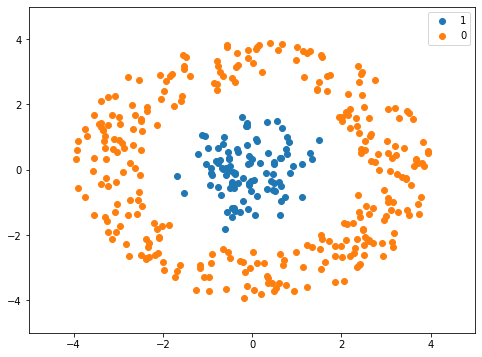

In [141]:
df_train = train_data()

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

c = df_train['y'] == 1
ax.scatter(df_train[c]['x_1'], df_train[c]['x_2'], marker='o', color='C0', label='1')
ax.scatter(df_train[~c]['x_1'], df_train[~c]['x_2'], marker='o', color='C1', label='0')
ax.legend()

plt.show()

And now let's make sure that we've implemented the algorithm correctly
and that we can indeed train a neural network with it.

In [183]:
# train a neural net
df_train = train_data()

features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

nn = ReLUNet([10, 10, 10, 10], random_seed=47)
data = nn.fit(**train_params)

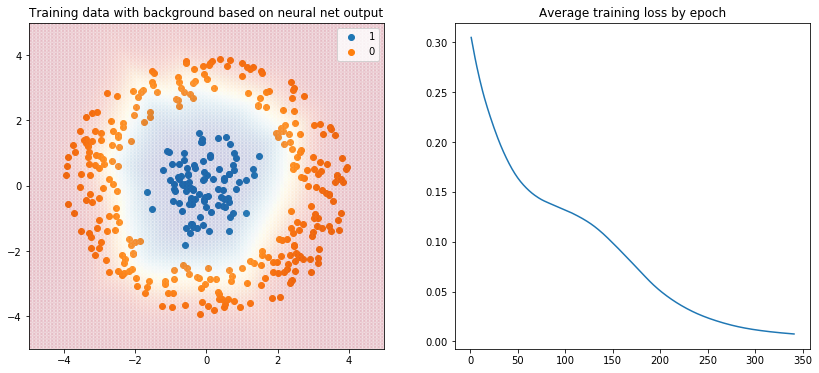

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_xlim([-5, 5])
ax[0].set_ylim([-5, 5])
c = df_train['y'] == 1
ax[0].scatter(df_train[c]['x_1'], df_train[c]['x_2'], marker='o', color='C0', label='1')
ax[0].scatter(df_train[~c]['x_1'], df_train[~c]['x_2'], marker='o', color='C1', label='0')
ax[0].legend()

x = np.linspace(-5, 5, 100)
xy = product(x, x)
df_background = pd.DataFrame(xy, columns=['x_1', 'x_2'])
df_background['const'] = 1
df_background[['x_1_norm', 'x_2_norm']] = normalize_data(df_background)
y_raw = nn.raw_output(df_background[['x_1_norm', 'x_2_norm', 'const']], False)
df_background['predict_proba'] = y_raw
ax[0].scatter(df_background['x_1'],
              df_background['x_2'],
              c=df_background['predict_proba'],
              cmap='RdYlBu',
              marker='o',
              alpha=0.05)
ax[0].set_title('Training data with background based on neural net output')

ax[1].set_title('Average training loss by epoch')
ax[1].plot([d['epoch'] for d in data], [d['avg_loss'] for d in data])

plt.show()

Let's take a 50 different random seeds to initialize a neural net and train it each tiem with
both training algorithms and see which is faster. It should be Adam. We'll use the 
Wilcoxon ranked-sum test since the observations are paired as Adam and SGD will start
with the same initial conditions.

We could certainly push SGD
to be faster than it is by not taking the average when we update the weights, but we've had to
do that just to get convergence. I will not play around with different ways to do that by
taking, say, the 10 most recent set of weights only in the average or something like that.

In [208]:
from scipy.stats import wilcoxon

# train a neural net
df_train = train_data()

features = [
    'x_1_norm'
    ,'x_2_norm'
    ,'const'
]

train_params = {
    'x': df_train[features]
    ,'y': df_train['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': df_train.shape[0]
    ,'save_data': True
}

adam_epochs = []
sgd_epochs = []

for i in range(50):

    nn = ReLUNet([10, 10, 10, 10], random_seed=i)
    data_adam = nn.fit(algorithm='adam', **train_params)
    adam_epochs.append(data_adam[-1]['epoch'])

    # reset parameters
    nn.w = data_adam[0]['w']
    data_sgd = nn.fit(algorithm='sgd', **train_params)
    sgd_epochs.append(data_sgd[-1]['epoch'])

print('Adam: median number of epochs required:', np.median(adam_epochs))
print('Adam:   mean number of epochs required:', np.mean(adam_epochs))
print('\nSGD: median number of epochs required:', np.median(sgd_epochs))
print('SGD:   mean number of epochs required:', np.mean(sgd_epochs))
print('\nWilcoxon ranked-sign test p-value: {:.2e}'.format(wilcoxon(adam_epochs, sgd_epochs).pvalue))

Adam: median number of epochs required: 264.5
Adam:   mean number of epochs required: 284.36

SGD: median number of epochs required: 568.0
SGD:   mean number of epochs required: 638.14

Wilcoxon ranked-sign test p-value: 1.15e-09


As expected, Adam is much faster than SGD, more than twice as fast on average. And that's it, that concludes this post, which 
is very short!